# Logistic Regression

In [1]:
pip install pandas scikit-learn numpy matplotlib seaborn joblib streamlit

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

In [5]:
# Load the training dataset
train_df = pd.read_csv("Titanic_train.csv")


In [6]:
# Display initial information
print("--- Training Data Info ---")
print(train_df.info())

--- Training Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [7]:
# Define the features we will use for the model
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
target = 'Survived'

In [8]:
X = train_df[features]
y = train_df[target]

## EDA

Text(0.5, 1.0, 'Survival Rate by Sex')

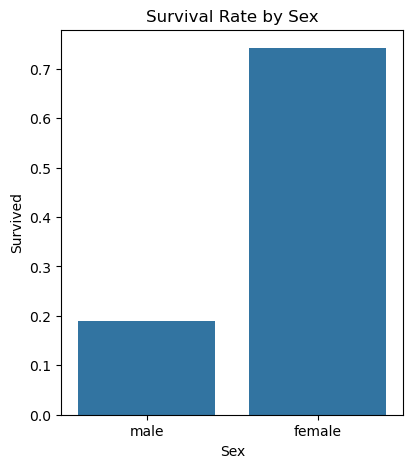

In [9]:
# 1. Survival by Sex
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.barplot(x='Sex', y='Survived', data=train_df, errorbar=None)
plt.title('Survival Rate by Sex')


Text(0.5, 1.0, 'Survival Rate by Pclass')

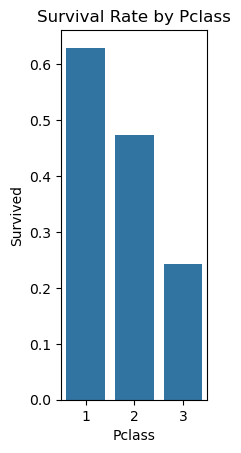

In [10]:
# 2. Survival by Pclass
plt.subplot(1, 3, 2)
sns.barplot(x='Pclass', y='Survived', data=train_df, errorbar=None)
plt.title('Survival Rate by Pclass')


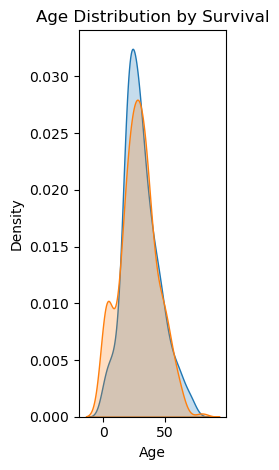

In [11]:
# 3. Age Distribution vs Survival (KDE Plot)
plt.subplot(1, 3, 3)
sns.kdeplot(train_df[train_df['Survived'] == 0]['Age'].dropna(), label='Did Not Survive', fill=True)
sns.kdeplot(train_df[train_df['Survived'] == 1]['Age'].dropna(), label='Survived', fill=True)
plt.title('Age Distribution by Survival')
plt.tight_layout()
plt.show() # Display the plot

## Building the Preprocessing Pipeline


In [12]:
# Identify feature types
numerical_features = ['Age', 'SibSp', 'Parch', 'Fare']
categorical_features = ['Pclass', 'Sex', 'Embarked']

# 1. Pipeline for Numerical features (Impute missing Age/Fare with Median)
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

In [13]:
# 2. Pipeline for Categorical features (Impute missing Embarked with Mode, then One-Hot Encode)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # drop='first' is important to avoid multicollinearity (the 'dummy variable trap')
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

In [14]:
# 3. Combine both pipelines using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [15]:
# Apply preprocessing to X and transform it into a numpy array
X_processed = preprocessor.fit_transform(X)

# Split the processed data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

# Model Training and Evaluation

## Train the Logistic Regression Model

In [16]:
# Initialize the Logistic Regression model
model = LogisticRegression(solver='liblinear', random_state=42, max_iter=500)

# Train the model
model.fit(X_train, y_train)

# Save the trained model and preprocessor for deployment
joblib.dump(model, 'logistic_regression_model.pkl')
joblib.dump(preprocessor, 'preprocessor.pkl')
print("Model and Preprocessor saved as .pkl files.")

Model and Preprocessor saved as .pkl files.


## Evaluate Performance and ROC Curve

In [17]:
# Make predictions and get probabilities
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1] # Probability of survival (class 1)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

In [18]:
print("--- Model Evaluation Metrics ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

--- Model Evaluation Metrics ---
Accuracy: 0.8101
Precision: 0.8070
Recall: 0.6667
F1-Score: 0.7302
ROC-AUC Score: 0.8394


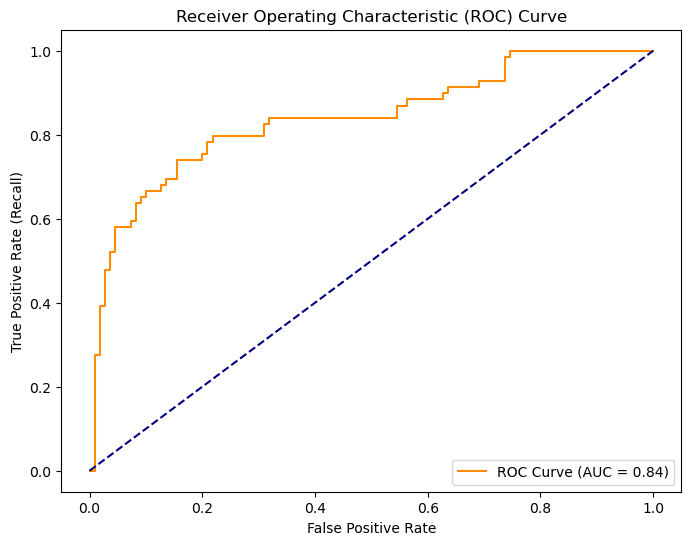

In [19]:
# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.legend(loc="lower right")
plt.show() # Display the plot

## Interpret Coefficients

In [20]:
# Get the feature names after one-hot encoding
feature_names = numerical_features + list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features))
feature_names = [f.replace('onehot__', '') for f in feature_names] # Clean up prefixes

# Create a DataFrame for interpretation
coefficients = model.coef_[0]
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient (Log-Odds)': coefficients,
    'Odds Ratio (e^Coef)': np.exp(coefficients)
})

# Sort for easy reading
coef_df = coef_df.sort_values(by='Odds Ratio (e^Coef)', ascending=True).reset_index(drop=True)

print("\n--- Model Coefficients and Odds Ratios ---")
print(coef_df)


--- Model Coefficients and Odds Ratios ---
      Feature  Coefficient (Log-Odds)  Odds Ratio (e^Coef)
0    Sex_male               -2.420050             0.088917
1    Pclass_3               -1.635355             0.194883
2    Pclass_2               -0.519930             0.594562
3  Embarked_S               -0.314476             0.730172
4       SibSp               -0.227329             0.796658
5       Parch               -0.076039             0.926780
6         Age               -0.028695             0.971712
7        Fare                0.005722             1.005738
8  Embarked_Q                0.323586             1.382075
